# Meridional heat flux


Note: OM2-025 does not have the required output, using a different experiment `*_bgc` instead of `*_gadi` compared to other scripts.

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44269/status,
Dashboard: /proxy/44269/status,Workers: 7
Total threads: 28,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43635,Workers: 7
Dashboard: /proxy/44269/status,Total threads: 28
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:46815,Total threads: 4
Dashboard: /proxy/36017/status,Memory: 18.29 GiB
Nanny: tcp://127.0.0.1:36895,


In [3]:
# CM2 database
#session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/cj877.db') 
session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'  # '025deg_jra55_ryf9091_bgc'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

In [5]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [6]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

## Ocean

https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/meridional_heat_transport/Meridional_Heat_Transport.ipynb

In [7]:
start_time = '0400-01-01'
end_time   = '0499-12-31'

In [8]:
area_t_25 = cc.querying.getvar(expt_OM2_025, 'area_t', session_OM2, n=1).load()
area_t_1  = cc.querying.getvar(expt_OM2_1, 'area_t', session_OM2, n=1).load()

In [9]:
lat_25 = cc.querying.getvar(expt_OM2_025, 'geolat_t', session_OM2, n=1).load()
lat_1 = cc.querying.getvar(expt_OM2_1, 'geolat_t', session_OM2, n=1).load()

In [10]:
latv_25 = cc.querying.getvar(expt_OM2_025, 'yt_ocean', session_OM2, n=1).load()
latv_1 = cc.querying.getvar(expt_OM2_1, 'yt_ocean', session_OM2, n=1).load()

In [11]:
def get_MHF(shflux, area, lat, latv):
    
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux.where(lat < latv[i]))
    
    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return MHF

Load data

In [ ]:
shflux_CM2_025 =  cc.querying.getvar(expt_CM2_025, 'net_sfc_heating', session_CM2, start_time=start_time, end_time=end_time)
shflux_CM2_025 = shflux_CM2_025.sel(time=slice(start_time, end_time))

In [ ]:
shflux_CM2_1 =  cc.querying.getvar(expt_CM2_1, 'net_sfc_heating', session_CM2, start_time=start_time, end_time=end_time)
shflux_CM2_1 = shflux_CM2_1.sel(time=slice(start_time, end_time))

In [ ]:
shflux_OM2_025 = cc.querying.getvar(expt_OM2_025, 'net_sfc_heating', session_OM2, start_time='2300-01-01', end_time='2399-12-31')
shflux_OM2_025 = shflux_OM2_025.sel(time=slice('2300-01-01', '2399-12-31'))

In [ ]:
shflux_OM2_1 =  cc.querying.getvar(expt_OM2_1, 'net_sfc_heating', session_OM2, start_time='2300-01-01', end_time='2399-12-31')
shflux_OM2_1 = shflux_OM2_1.sel(time=slice('2300-01-01', '2399-12-31'))

Load time averaged data

In [16]:
shflux_CM2_025 = shflux_CM2_025.mean('time').load()

In [17]:
shflux_CM2_1   = shflux_CM2_1.mean('time').load()
# Overwrite yt_ocean values
shflux_CM2_1['yt_ocean'] = area_t_1.yt_ocean.values

In [18]:
shflux_OM2_025 = shflux_OM2_025.mean('time').load()

In [19]:
shflux_OM2_1   = shflux_OM2_1.mean('time').load()

Calculate merdifional heat flux (MHF)

In [20]:
%%time
MHF_CM_25 = get_MHF(shflux_CM2_025, area_t_25, lat_25, latv_25)

CPU times: user 30.6 s, sys: 671 ms, total: 31.2 s
Wall time: 28.3 s


In [21]:
%%time
MHF_CM_1 = get_MHF(shflux_CM2_1, area_t_1, lat_1, latv_1)

CPU times: user 2.12 s, sys: 69.2 ms, total: 2.18 s
Wall time: 2.03 s


In [22]:
MHF_OM_25 = get_MHF(shflux_OM2_025, area_t_25, lat_25, latv_25)

In [23]:
MHF_OM_1 = get_MHF(shflux_OM2_1, area_t_1, lat_1, latv_1)

Observational estimates

(-2.0, 2.5)

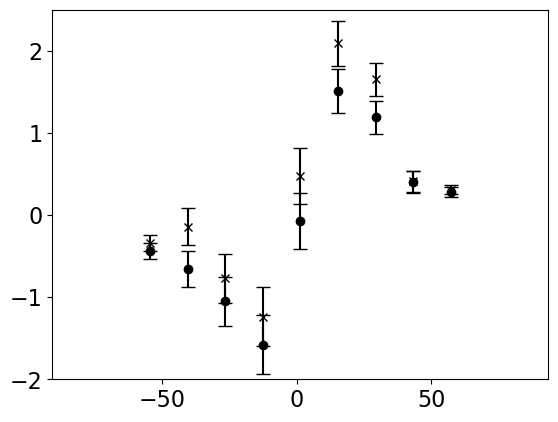

In [24]:
import pandas as pd

# Read in observed meridional heat transport from Trenberth and Caron (http://www.cgd.ucar.edu/cas/catalog/ocean/ohts/rean_ohts.html)
df=pd.read_csv('/g/data/x77/wgh581/Analysis/ACCESS-CM2-025_Analysis/notebooks/ANNUAL_TRANSPORTS_1985_1989.ascii.txt', sep=' ', skiprows=1, skipinitialspace=True)
obs_lat = df.values[:,0]/100.
obs_ncep = df.values[:,6]/100.
obs_ncep_er = df.values[:,10]/100
obs_ecmwf = df.values[:,14]/100.
obs_ecmwf_er = df.values[:,18]/100.
plt.errorbar(obs_lat[::5], obs_ncep[::5], yerr=obs_ncep_er[::5], fmt='xk', capsize=5)
plt.errorbar(obs_lat[::5], obs_ecmwf[::5], yerr=obs_ecmwf_er[::5], fmt='ok', capsize=5)
plt.ylim([-2, 2.5])

(-2.0, 2.5)

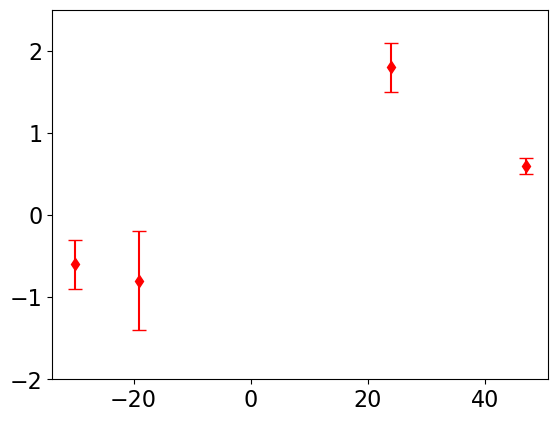

In [25]:
# Read in observed MHT from Ganachaud and Wunsch 2000 (
df=pd.read_csv('/g/data/x77/wgh581/Analysis/ACCESS-CM2-025_Analysis/notebooks/GW2003_GlobalMHT.txt', sep=' ', skiprows=0, skipinitialspace=True)
obsGW2003_lat = df.values[:,0]
obsGW2003_mht = df.values[:,1]
obsGW2003_mhte = df.values[:,2]
plt.errorbar(obsGW2003_lat, obsGW2003_mht, yerr=obsGW2003_mhte, fmt='dr', capsize=5)
plt.ylim([-2, 2.5])

Plotting

In [26]:
CLEX_Red = '#DA1E48'
CLEX_Pink = '#F48580'
CLEX_SkyBlue = '#00BDF2'
CLEX_MidBlue = '#008DD0'
CLEX_CobaldBlue = '#0066B3'
CLEX_MidnightBlue = '#113559'
CLEX_Gray = '#4D4D47'

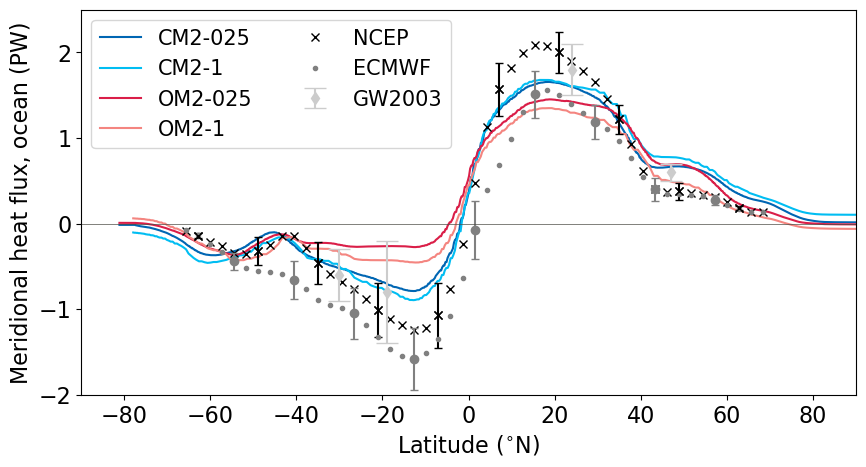

In [27]:
fig = plt.figure(figsize=(10,5))

plt.plot(latv_25, MHF_CM_25*1e-15, color=CLEX_CobaldBlue, label='CM2-025')
plt.plot(latv_1, MHF_CM_1*1e-15, color=CLEX_SkyBlue, label='CM2-1')
plt.plot(latv_25, MHF_OM_25*1e-15, color=CLEX_Red, label='OM2-025')
plt.plot(latv_1, MHF_OM_1*1e-15, color=CLEX_Pink, label='OM2-1')
plt.plot(obs_lat, obs_ncep, 'xk', label='NCEP', markersize=6)
plt.errorbar(obs_lat[3::5], obs_ncep[3::5], yerr=obs_ncep_er[3::5], fmt='xk', capsize=3)
plt.plot(obs_lat, obs_ecmwf, 'o', color='0.5', label='ECMWF', markersize=3)
plt.errorbar(obs_lat[::5], obs_ecmwf[::5], yerr=obs_ecmwf_er[::5], fmt='o', color='0.5', capsize=3)
plt.errorbar(obsGW2003_lat, obsGW2003_mht, yerr=obsGW2003_mhte, fmt='d', color='0.8', capsize=8, label='GW2003')
plt.legend(ncol=2, fontsize=ft_size-1)
plt.axhline(0, linewidth=0.5, color=CLEX_Gray)
plt.xlim(-90, 90)
plt.ylim([-2, 2.5])
plt.xlabel('Latitude ($^{\circ}$N)')
plt.ylabel('Meridional heat flux, ocean (PW)')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_MHT_ocean.png'
    plt.savefig(fig_path + fig_name, dpi=300);

Things to note:
- 0.25 has less transpport than 1 in SH (and more transport in NH)
- Larger difference between models than resolution
- All models have less transport than what observational estimates suggest

Some numbers

In [71]:
print('Maximum transport (SH, NH), in PW')
print('CM2-025: ', np.round(MHF_CM_25.min()*1e-15, 2), np.round(MHF_CM_25.max()*1e-15, 2))
print('CM2-1: ', np.round(MHF_CM_1.min()*1e-15, 2), np.round(MHF_CM_1.max()*1e-15, 2))
print('OM2-025: ', np.round(MHF_OM_25.min()*1e-15, 2), np.round(MHF_OM_25.max()*1e-15, 2))
print('OM2-1: ', np.round(MHF_OM_1.min()*1e-15, 2), np.round(MHF_OM_1.max()*1e-15, 2))

Maximum transport (SH, NH), in PW
CM2-025:  -0.79 1.66
CM2-1:  -0.89 1.68
OM2-025:  -0.37 1.45
OM2-1:  -0.45 1.35


In [112]:
print('Transport at 30 S, 30 N), in PW')
print('CM2-025: ', np.round(MHF_CM_25[372]*1e-15, 2), np.round(MHF_CM_25[623]*1e-15, 2))
print('CM2-1: ', np.round(MHF_CM_1[77]*1e-15, 2), np.round(MHF_CM_1[196]*1e-15, 2))
print('OM2-025: ', np.round(MHF_OM_25[372]*1e-15, 2), np.round(MHF_OM_25[623]*1e-15, 2))
print('OM2-1: ', np.round(MHF_OM_1[77]*1e-15, 2), np.round(MHF_OM_1[196]*1e-15, 2))

Transport at 30 S, 20 N), in PW
CM2-025:  -0.52 1.46
CM2-1:  -0.53 1.57
OM2-025:  -0.25 1.37
OM2-1:  -0.36 1.24
